In [62]:
from pathlib import Path
from radiosim.data import radiosim_data
import matplotlib.pyplot as plt
import numpy as np
from radionets.evaluation.jet_angle import calc_jet_angle
from scipy import ndimage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

In [2]:
sim_moj = Path("../resources/sim_moj")

In [3]:
moj_sources = radiosim_data(sim_moj)

In [236]:
s = moj_sources[0][0][0]

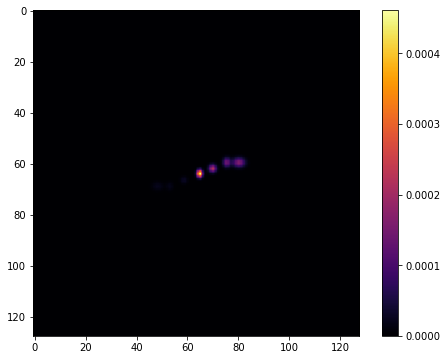

In [237]:
plt.figure(figsize=(8, 6))
plt.imshow(s, cmap="inferno")
plt.colorbar()

In [238]:
def get_rot(img):
    img[img <= img.max() * 0.001] = 1e-6
    img_log = np.log(img)
    offset = img_log.min() + 1

    m, n, angle = calc_jet_angle(img_log[None] - offset)
    if angle > 0:
        angle -= 90
    print(angle)
    img_rot = ndimage.rotate(img, angle)
    img_1d = np.sum(img_rot, axis=0)
    return img_rot, img_1d, m, n

In [239]:
s_rot, s_1d, m, n = get_rot(s)

tensor([-17.6596121895690175], dtype=torch.float64)


/home/kschmidt_local/.local/anaconda3/envs/radionets/lib/python3.9/site-packages/scipy/ndimage/interpolation.py:910: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rot_matrix = numpy.array([[c, s],
/home/kschmidt_local/.local/anaconda3/envs/radionets/lib/python3.9/site-packages/scipy/ndimage/interpolation.py:910: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rot_matr

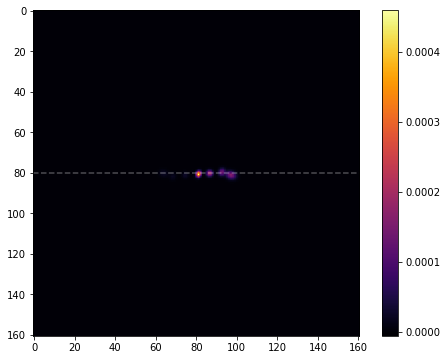

In [240]:
plt.figure(figsize=(8, 6))
plt.axhline(y=s_rot.shape[0]//2, xmin=0, xmax=1, color='w', alpha=0.3, linestyle='--')
plt.imshow(s_rot, cmap="inferno")
plt.colorbar()

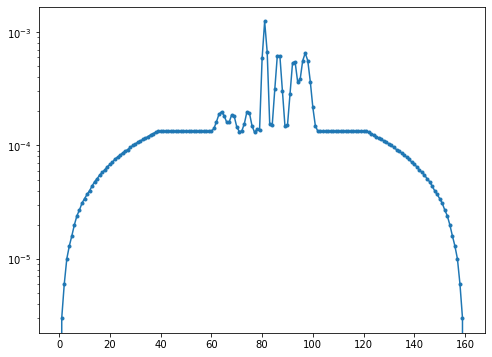

In [241]:
plt.figure(figsize=(8, 6))
plt.plot(s_1d, marker=".")
plt.yscale("log")

/tmp/ipykernel_759325/432824320.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(max_vals))


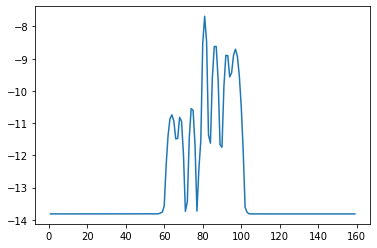

In [242]:
max_vals = np.max(s_rot, axis=0)

plt.plot(np.log(max_vals))

In [243]:
def lin(x, m, n):
    return m * x + n


def calc_powerlaw_index(img_rot):
    max_vals = np.max(img_rot, axis=0)
    max_vals = np.log(max_vals)
    cut = max_vals[~np.isinf(max_vals)].min() * 0.8
    max_vals[max_vals <= cut] = 0
    
    max_vals = max_vals[max_vals != 0]
    peaks, _ = find_peaks(max_vals, )#threshold=0.02)
    print(peaks)
    if len(peaks) <= 1:
        smooth_d2 = np.gradient(np.gradient(max_vals))
        infls = np.where(np.diff(np.sign(smooth_d2)))[0]
        infls = np.append(infls, infls.max()+1)
        print(infls)
        peaks = np.append(peaks, infls)
    order = peaks[np.argsort(max_vals[peaks])[::-1]]
    if len(order) > 1:
        dif = order[0] - order[1]
        if dif >= 0:
            peaks = peaks[peaks <= order[0]]
            max_vals = max_vals[:order[0]+1]
        else:
            peaks = peaks[peaks >= order[0]]
            max_vals = max_vals[order[0]:]
            peaks -= peaks[0]
    print(peaks)
    plt.plot(max_vals)
    plt.show()
    params, cov = curve_fit(lin, peaks, max_vals[peaks], maxfev=2000)
    return params, peaks, max_vals

[ 1  3  5  8 11 15 20]
[ 0  3  7 12]


/tmp/ipykernel_759325/2138048434.py:7: RuntimeWarning: divide by zero encountered in log
  max_vals = np.log(max_vals)


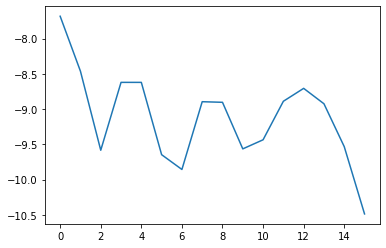

In [244]:
params, peaks, max_vals = calc_powerlaw_index(s_rot)

-0.07560726988065136


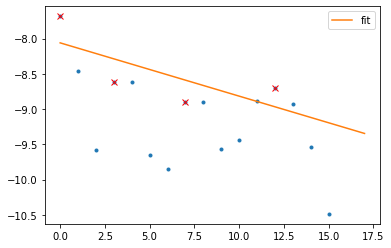

In [245]:
plt.plot(range(len(max_vals)), max_vals, marker=".", linestyle="none")
plt.plot(peaks, max_vals[peaks], "rx")

t = np.linspace(0, peaks.max() + 5, 100)
plt.plot(t, lin(t, *params), label="fit")
plt.legend()

index = params[0]
if index > 0:
    index = -index
print(index)